# (new) estimation of spiral tip lifetimes
Tim Tyree<br>
12.15.2021

In [79]:
from lib.my_initialization import *
from lib import *
# from lib.measure.unwrap_and_smooth_cu import *
# from lib.rapids_func import *
# .routines.unwrap_and_smooth_trajectories_cu import *

import itertools
import dask_cudf
from lib.rapids_func import *
get_DT_cu

#magic    
%autocall 1
%load_ext autoreload
%autoreload 2

import cupy as cp, cudf, numba.cuda as cuda
import rmm
# Switch to RMM allocator
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

Automatic calling is: Smart
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# compute lifetimes the old, slow, and complicated way

In [2]:
##########################
# Perform Averaging
##########################
tavg1=0
tavg2=14#todo 0
#one token trajectory file for the fenton karma model and the luo-rudy model
input_fn_lst=[
# c='C0'
# # # # #token FK at DT=0.4
"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv",
# c='C1'
# #tokenLR at DT=0.5
"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.11_traj_sr_600_mem_0.csv",   
]

data_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_fk_tavg1_0.0_tavg2_14.00.csv'
data_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_lr_tavg1_0.0_tavg2_14.00.csv'

In [3]:
print(f"estimated runtime: {4+0.5} minutes")
df_annihilation=cudf.read_csv(data_dir_fk)
event_index_values=df_annihilation[['event_id_int','pid_self','pid_other']].drop_duplicates().values.get()
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv"
input_fn_lst=get_all_files_matching_pattern(input_fn,trgt='_unwrap.csv')
print(len(input_fn_lst))
lifetime_lst_lst=[comp_lifetimes(input_fn,event_index_values) for input_fn in input_fn_lst]

df_annihilation=cudf.read_csv(data_dir_fk)
event_index_values=df_annihilation[['event_id_int','pid_self','pid_other']].drop_duplicates().values.get()

#FK
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv"
input_fn_lst=get_all_files_matching_pattern(input_fn,trgt='_unwrap.csv')
print(f"computing lifetimes for {len(input_fn_lst)} trials.")
lifetime_lst_lst=[comp_lifetimes(input_fn,event_index_values) for input_fn in input_fn_lst]
lifetime_values=np.concatenate(lifetime_lst_lst)
lifetime_values_FK=lifetime_values.copy()

estimated runtime: 4.5 minutes
324


KeyboardInterrupt: 

In [ ]:
#LR
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories_unwrap/ic001.33_traj_sr_600_mem_0_unwrap.csv"
df_annihilation=cudf.read_csv(data_dir_lr)
event_index_values=df_annihilation[['event_id_int','pid_self','pid_other']].drop_duplicates().values.get()
input_fn_lst=get_all_files_matching_pattern(input_fn,trgt='_unwrap.csv')
print(f"computing lifetimes for {len(input_fn_lst)} trials.")
lifetime_lst_lst=[comp_lifetimes(input_fn,event_index_values) for input_fn in input_fn_lst]
lifetime_values_LR=np.concatenate(lifetime_lst_lst)

In [ ]:
print(getsource(comp_lifetimes))

In [181]:
#bootstrap the mean for either case
values=lifetime_values_FK.copy()
mean_value,Delta_mean,p=bootstrap_mean_95CI_and_print_cu(values)
print(f"num_samples={values.shape[0]}")

values=lifetime_values_LR.copy()
mean_value,Delta_mean,p=bootstrap_mean_95CI_and_print_cu(values)
print(f"num_samples={values.shape[0]}")

the mean value is 0.3101+/-0.0035, with test for normality (p=0.5399)
num_samples=43306
the mean value is 0.0827+/-0.0009, with test for normality (p=0.3152)
num_samples=10362


# compute mean lifetime of all spiral tips for the luo-rudy model and the fenton karma model the simple way

In [239]:
# from inspect import getsource

In [240]:
# #TODO: dev comp_lifetimes_simple from comp_lifetimes
# # print (getsource (comp_lifetimes) )
# def comp_lifetimes_simple(input_fn,pid_col='particle'):
#     """
#     Example Usage:
# lifetime_lst=comp_lifetimes_simple(input_fn)
#     """
#     #for each pid, compute v_rms and the lifetime
#     df=pd.read_csv(input_fn)
#     pid_values=df[pid_col].values
#     lifetime_lst=[]
#     for pid in pid_values:
#         #compute time series data
#         txy_values=df.loc[df[pid_col]==pid,['t','x','y']].values
#         t_values=txy_values[:,0]-np.min(txy_values[:,0])
#         #compute particle averaged values
#         lifetime=(np.max(t_values)-np.min(t_values))*1e-3 #seconds
#         #record
#         lifetime_lst.append(lifetime)
#     return lifetime_lst

In [241]:
# def routine(input_fn):
#     pid_col='particle'
#     t_col='t'
#     df=pd.read_csv(input_fn)
#     groups=df.groupby(pid_col)
#     lifetime_lst=[]
#     for n,g in groups:
#         lifetime=g['t'].max()-g['t'].min()
#         lifetime*=1e-3 #seconds
#         lifetime_lst.append(lifetime)
#     return lifetime_lst

In [242]:
# # TODO: test this works and the results are reasonable on 1 input_fn
# lifetime_lst=comp_lifetimes_simple(input_fn)

# #TODO: make a dask bag do this

In [9]:
def comp_lifetimes_simpler(
        input_fn,
        pid_col='particle',
        t_col='t'):
    """
    Example Usage:
df_lifetime=comp_lifetimes_simpler(input_fn)
    """
    df=pd.read_csv(input_fn)
    groups=df.groupby(pid_col)
    lifetime_lst=[]
    pid_lst=[]
    tmax_lst=[]
    tmin_lst=[]
    for pid,g in groups:
        tmin=g['t'].min()
        tmax=g['t'].max()
        lifetime=tmax-tmin
        lifetime*=1e-3 #seconds
        #record
        pid_lst.append(pid)
        tmin_lst.append(tmin)
        tmax_lst.append(tmax)
        lifetime_lst.append(lifetime)
    df_lifetime=pd.DataFrame({
        pid_col:pid_lst,
        'tmin':tmin_lst,
        'tmax':tmax_lst,
        'lifetime':lifetime_lst
    })
    return df_lifetime

In [10]:
printing=True

In [11]:
#LR
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic001.33_traj_sr_600_mem_0.csv"
# df_annihilation=cudf.read_csv(data_dir_lr)
# event_index_values=df_annihilation[['event_id_int','pid_self','pid_other']].drop_duplicates().values.get()
input_fn_lst=get_all_files_matching_pattern(input_fn,trgt='.csv')
print(f"computing lifetimes for {len(input_fn_lst)} trials.")

npartitions=10
df_lifetime=comp_lifetimes_simpler(input_fn)
def routine(input_fn):
    return comp_lifetimes_simpler(input_fn)
#all CPU version
b = db.from_sequence(input_fn_lst, npartitions=npartitions).map(routine)
start = time.time()
retval = list(b)

if printing:
    print(f"run time for bootstrapping was {time.time()-start:.2f} seconds.")
df_lifetime_lst=retval

df_lifetimes=pd.concat(df_lifetime_lst)
# df_lifetimes.shape

print(f"Luo-Rudy Model:")
num_particles=df_lifetimes.shape[0]
num_trials=len(input_fn_lst)
# num_particles/num_trials
#DONE: compute & print mean lifetime value
GammaBar_Observed=np.mean(df_lifetimes['lifetime'])#.shape
std_GammaBar_Observed=np.std(df_lifetimes['lifetime'])#.shape
Deltahat_GammaBar_Observed=1.96*np.std(df_lifetimes['lifetime'])/np.sqrt(num_particles/num_trials)#.shape
# Deltahat_GammaBar_Observed=1.96*np.std(df_lifetimes['lifetime'])/np.sqrt(num_particles)#.shape
# Delta_GammaBar_Observed=np.mean(df_lifetimes['lifetime'])#.shape
print(f"mean lifetime is {GammaBar_Observed*1e3:.4f} milliseconds")
print(f"stdev lifetime is {std_GammaBar_Observed*1e3:.4f} milliseconds")
print(f"Deltahat_lifetime is {Deltahat_GammaBar_Observed*1e3:.4f} milliseconds")
print(f"Deltahat_lifetime was computed as stdev(.)/np.sqrt(mean_number_particles_per_termination_event)")
print(f"mean_number_particles_per_termination_event: {num_particles/num_trials:.4f}")
lifetime_values_LR=df_lifetimes['lifetime'].values
#TODO: what's the standard error of 1 trial?
# hint: what is num_particles/num_trials

computing lifetimes for 159 trials.
run time for bootstrapping was 106.18 seconds.
Luo-Rudy Model:
mean lifetime is 15.5618 milliseconds
stdev lifetime is 34.7995 milliseconds
Deltahat_lifetime is 0.9529 milliseconds
Deltahat_lifetime was computed as stdev(.)/np.sqrt(mean_number_particles_per_termination_event)
mean_number_particles_per_termination_event: 5123.4843


In [12]:
df_lifetimes_lr=df_lifetimes.copy()

In [13]:
#FK
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv"
# input_fn_lst=get_all_files_matching_pattern(input_fn,trgt='_unwrap.csv')
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv"
input_fn_lst=get_all_files_matching_pattern(input_fn,trgt='.csv')
input_fn_lst=[x for x in input_fn_lst if (x.find('_traj')!=-1)&(x.find('_unwrap')==-1)]
print(f"computing lifetimes for {len(input_fn_lst)} trials.")
# lifetime_lst_lst=[comp_lifetimes(input_fn,event_index_values) for input_fn in input_fn_lst]
# lifetime_values=np.concatenate(lifetime_lst_lst)
# lifetime_values_FK=lifetime_values.copy()

npartitions=10
df_lifetime=comp_lifetimes_simpler(input_fn)
def routine(input_fn):
    return comp_lifetimes_simpler(input_fn)
#all CPU version
b = db.from_sequence(input_fn_lst, npartitions=npartitions).map(routine)
start = time.time()
retval = list(b)

if printing:
    print(f"run time for bootstrapping was {time.time()-start:.2f} seconds.")
df_lifetime_lst=retval

df_lifetimes=pd.concat(df_lifetime_lst)
df_lifetimes.shape

print(f"Fenton-Karma Model:")
num_particles=df_lifetimes.shape[0]
num_trials=len(input_fn_lst)
# num_particles/num_trials
#DONE: compute & print mean lifetime value
GammaBar_Observed=np.mean(df_lifetimes['lifetime'])#.shape
std_GammaBar_Observed=np.std(df_lifetimes['lifetime'])#.shape
Deltahat_GammaBar_Observed=1.96*np.std(df_lifetimes['lifetime'])/np.sqrt(num_particles/num_trials)#.shape
# Deltahat_GammaBar_Observed=1.96*np.std(df_lifetimes['lifetime'])/np.sqrt(num_particles)#.shape
# Delta_GammaBar_Observed=np.mean(df_lifetimes['lifetime'])#.shape
print(f"mean lifetime is {GammaBar_Observed*1e3:.4f} milliseconds")
print(f"stdev lifetime is {std_GammaBar_Observed*1e3:.4f} milliseconds")
print(f"Deltahat_lifetime is {Deltahat_GammaBar_Observed*1e3:.4f} milliseconds")
print(f"Deltahat_lifetime was computed as stdev(.)/np.sqrt(mean_number_particles_per_termination_event)")
print(f"mean_number_particles_per_termination_event: {num_particles/num_trials:.4f}")
lifetime_values_FK=df_lifetimes['lifetime'].values
#TODO: what's the standard error of 1 trial?
# hint: what is num_particles/num_trials
df_lifetimes_fk=df_lifetimes.copy()

computing lifetimes for 324 trials.
run time for bootstrapping was 74.26 seconds.
Fenton-Karma Model:
mean lifetime is 197.3891 milliseconds
stdev lifetime is 337.2714 milliseconds
Deltahat_lifetime is 36.3267 milliseconds
Deltahat_lifetime was computed as stdev(.)/np.sqrt(mean_number_particles_per_termination_event)
mean_number_particles_per_termination_event: 331.1451


In [14]:
# lifetime_values_FK*=1e3
# lifetime_values_LR*=1e3

# #DONE: save results as pkl
# import pickle

# dict_lifetimes = {'lr': {'tbins':bins, 'pdf_bar_heights':bar_heights_lr},
#      'fk': {'tbins':bins, 'pdf_bar_heights':bar_heights_fk}
#     }

# lifetime_pdf_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/lifetimes.pkl"

# with open(lifetime_pdf_dir, 'wb') as handle:
#     pickle.dump(dict_lifetimes, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(lifetime_pdf_dir, 'rb') as handle:
#     b = pickle.load(handle)
    
# # assert dict_lifetimes==b
# type(b)

NameError: name 'bins' is not defined

In [ ]:
beep(3)

In [ ]:
# #TODO: save lifetime values as npz
# lifetime_values_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/lifetime_values.npz"
# np.savez_compressed?
# data=dict(lifetime_values_LR=lifetime_values_LR,lifetime_values_FK=lifetime_values_FK)
# type(data)

In [16]:
#save results as .csv with lifetime in units of seconds
lifetime_values_fk_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/lifetime_values_fk.csv"
df_lifetimes_fk.to_csv(lifetime_values_fk_dir,index=False)
lifetime_values_lr_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/lifetime_values_lr.csv"
df_lifetimes_lr.to_csv(lifetime_values_lr_dir,index=False)

In [251]:
#  MemoryError: std::bad_alloc: CUDA error at:
#                         # #bootstrap the mean for either case
# # values=lifetime_values_FK.copy()
# # mean_value,Delta_mean,p=bootstrap_mean_95CI_and_print_cu(values)
# # print(f"num_samples={values.shape[0]}")

# # values=lifetime_values_LR.copy()
# # mean_value,Delta_mean,p=bootstrap_mean_95CI_and_print_cu(values)
# # print(f"num_samples={values.shape[0]}")

## notes on exp lifetime fits

__Evidence in Support of Consistency of the Isoparameteric Annihilation Theory with the Short-Lived Luo-Rudy (LR) model__
> np.mean(df_lifetime['lifetime'])

yielded 0.0157177835050894 seconds

- ^that just said the mean lifetime for one LR trial was 15.7ms...
- ^that is within striking distance of the 12ms value for the effective lifetime


DONE: measure whether the ensemble averaged lifetime is consistent with the effective lifetime.
- A: Yes. It's dang close to 12 milliseconds.

`
    Luo-Rudy Model:
    mean lifetime is 15.5618 milliseconds
    stdev lifetime is 34.7995 milliseconds
    Deltahat_lifetime is 0.9529 milliseconds
    Deltahat_lifetime was computed as stdev(.)/np.sqrt(mean_number_particles_per_termination_event)
    mean_number_particles_per_termination_event: 5123.4843
    `
- DONE: measure fenton-karma model apparent lifetime
- DONT(p said it was normally distributed...): measure the bootstrapped mean?    
- TODO: dev sketch figure 3 on ipad

before unwrapping

`
Fenton-Karma Model:
mean lifetime is 197.3891 milliseconds
stdev lifetime is 337.2714 milliseconds
Deltahat_lifetime is 36.3267 milliseconds
Deltahat_lifetime was computed as stdev(.)/np.sqrt(mean_number_particles_per_termination_event)
mean_number_particles_per_termination_event: 331.1451`


after unwrapping
`
    Fenton-Karma Model:
    mean lifetime is 208.8712 milliseconds
    stdev lifetime is 343.4686 milliseconds
    Deltahat_lifetime is 38.0550 milliseconds
    Deltahat_lifetime was computed as stdev(.)/np.sqrt(mean_number_particles_per_termination_event)
    mean_number_particles_per_termination_event: 312.9414
    `

# TODO: visualize the pdf and the cdf

In [94]:
lifetime_values_FK=df_lifetimes_fk['lifetime'].values
lifetime_values_LR=df_lifetimes_lr['lifetime'].values
# lifetime_values_FK*=1e3
# lifetime_values_LR*=1e3

lifetime_values_FK=lifetime_values_FK[lifetime_values_FK>0].copy()
lifetime_values_LR=lifetime_values_LR[lifetime_values_LR>0].copy()

In [95]:
bootstrap_mean_95CI_and_print_cu(lifetime_values_FK)

the mean value is 0.2089+/-0.0022, with test for normality (p=0.9486)


(0.20887115284092592, 0.0021591543150992353, 0.9486221210809824)

In [96]:
lifetime_values_FK.shape

(101393,)

In [97]:
bootstrap_mean_95CI_and_print_cu(
    values=lifetime_values_LR,
    seed=42,
    printing=True,
    num_samples=100,
    include_normaltest_slowly=True,
    use_seed=True)

the mean value is 0.0310+/-0.0001, with test for normality (p=0.6082)


(0.03099934466159479, 0.00012201346797704635, 0.608195786156621)

In [98]:
lifetime_values_LR.shape

(408949,)

__FK__
- the mean value is 0.2089+/-0.0022, with test for normality (p=0.9486) (N=101393)
- when including isolated spiral tip locations (trivial trajectories), we see
    - the mean value is 0.1974+/-0.0020, with test for normality (p=0.1554)
    
__LR__
- the mean value is 0.0310+/-0.0001, with test for normality (p=0.6082) (408949)
- when including isolated spiral tip locations (trivial trajectories), we see
    - the mean value is 0.0156+/-0.0001, with test for normality (p=0.7536)


In [19]:
bootstrap_mean_95CI_and_print_cu

<function lib.rapids_func.measure.bootstrap_cu.bootstrap_mean_95CI_and_print_cu(values, seed=42, printing=True, num_samples=1000, include_normaltest_slowly=True, use_seed=True, **kwargs)>

In [20]:
#ignore...
# bootstrap_mean_95CI_and_print_cu(lifetime_values_LR)
#  MemoryError: std::bad_alloc: CUDA error at: /home/timothytyree/anaconda3/envs/pyenv_ub/include/rmm/mr/device/cuda_memory_resource.hpp:69: cudaErrorMemoryAllocation out of memory 

In [391]:
0.07612186997198611*np.sqrt(159)

0.959860258056912

In [390]:
0.0761*np.sqrt(5e3)

5.3810826048296265

In [392]:
1.9058*1.96/2

1.867684

In [393]:
36.3267*1.96/2

35.600166

In [386]:
# scipy.stats.normaltest(lifetime_values_FK)

## visualize the distribution of particle lifetimes

In [27]:
# MemoryError: std::bad_alloc: CUDA error at
# #bootstrap the mean for either case
# values=lifetime_values_FK.copy()*1e3
# mean_value,Delta_mean,p=bootstrap_mean_95CI_and_print_cu(values)
# print(f"num_samples={values.shape[0]}")

# values=lifetime_values_LR.copy()*1e3
# mean_value,Delta_mean,p=bootstrap_mean_95CI_and_print_cu(values)
# print(f"num_samples={values.shape[0]}")
from lib.measure.exponential_fit import *

In [114]:
np.min(lifetime_values_FK),np.min(lifetime_values_LR)

(0.0003999999999996362, 0.0004999999999836291)

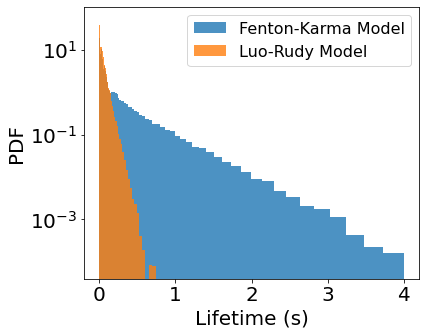

In [250]:
alpha=0.8
# bins=300
# bins='doane'
# bins='rice'
# bins='sqrt'
# 'auto', 'fd', 'doane',
#     'scott', 'stone', 'rice', 'sturges', or 'sqrt'.
bins=4*np.logspace(-3,0,100)
# bins=np.arange(0,4e3,60)*1e-3

#figure panel style histogram of lifetimes
fig,ax=plt.subplots(figsize=(6,5))
bar_heights_fk,bins,_=plt.hist(lifetime_values_FK,bins=bins,log=True,color='C0',density=True,alpha=alpha, label='Fenton-Karma Model')
bar_heights_lr,_,_=plt.hist(lifetime_values_LR,bins=bins,log=True,color='C1',density=True,alpha=alpha, label='Luo-Rudy Model')
plt.legend(fontsize=16)
format_plot(ax=plt.gca(),xlabel='Lifetime (s)',ylabel='PDF')
plt.show()

In [251]:
bins[0]

0.004

In [252]:
#TODO: compute exponential fit to all values
x=0.5*(bins[1:]+bins[:-1])

print(f"exponential fit for the Fenton-Karma model:")
xmin=2e2*1e-3
xmax=2e3*1e-3
boo=x<=xmax
boo&=x>=xmin
y=bar_heights_fk
# print_fit_exponential(x[boo],y[boo])
B,Delta_B,m,Delta_m,Rsq=fit_exponential(x[boo],y[boo])
GammaBar_observed=-1/m
Delta_GammaBar_observed=1/(m**2)*Delta_m
print(f"GammaBar_observed: {GammaBar_observed:.4f}+/-{Delta_GammaBar_observed:.4f} milliseconds")
yv=np.exp(B+x*m)
yv_fk=yv.copy()

print(f"\nexponential fit for the Luo-Rudy model:")
xmax=3.5#3e2*1e-3
boo=x<=xmax
boo&=bar_heights_lr>0
y=bar_heights_lr
# print_fit_exponential(x[boo],y[boo])
B,Delta_B,m,Delta_m,Rsq=fit_exponential(x[boo],y[boo])
GammaBar_observed=-1/m
Delta_GammaBar_observed=1/(m**2)*Delta_m
print(f"GammaBar_observed: {GammaBar_observed:.4f}+/-{Delta_GammaBar_observed:.4f} milliseconds")
yv=np.exp(B+x*m)
yv_lr=yv.copy()

exponential fit for the Fenton-Karma model:
GammaBar_observed: 0.4071+/-0.0134 milliseconds

exponential fit for the Luo-Rudy model:
GammaBar_observed: 0.0516+/-0.0013 milliseconds


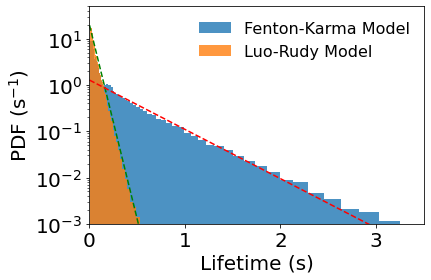

In [256]:
alpha=0.8
# bins=300
# bins='doane'
# bins='rice'
# bins='sqrt'
# 'auto', 'fd', 'doane',
#     'scott', 'stone', 'rice', 'sturges', or 'sqrt'.
# bins=2*np.logspace(-3,0,100)
# bins=np.arange(0,4e3,60)*1e-3

#figure panel style histogram of lifetimes
fig,ax=plt.subplots(figsize=(6,4))
bar_heights_fk,bins,_=plt.hist(lifetime_values_FK,bins=bins,log=True,color='C0',density=True,alpha=alpha, label='Fenton-Karma Model')
bar_heights_lr,_,_=plt.hist(lifetime_values_LR,bins=bins,log=True,color='C1',density=True,alpha=alpha, label='Luo-Rudy Model')
plt.plot(x,yv_lr,'g--')
plt.plot(x,yv_fk,'r--')
plt.xlim([0,3.5])
plt.ylim([1e-3,50])

plt.legend(fontsize=16,frameon=False)
format_plot(ax=plt.gca(),xlabel='Lifetime (s)',ylabel=r'PDF (s$^{-1}$)')
plt.show()

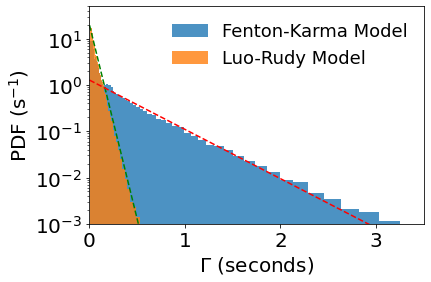

In [255]:
alpha=0.8
# bins=300
# bins='doane'
# bins='rice'
# bins='sqrt'
# 'auto', 'fd', 'doane',
#     'scott', 'stone', 'rice', 'sturges', or 'sqrt'.
# bins=2*np.logspace(-3,0,100)
# bins=np.arange(0,4e3,60)*1e-3

#figure panel style histogram of lifetimes
fig,ax=plt.subplots(figsize=(6,4))
bar_heights_fk,bins,_=plt.hist(lifetime_values_FK,bins=bins,log=True,color='C0',density=True,alpha=alpha, label='Fenton-Karma Model')
bar_heights_lr,_,_=plt.hist(lifetime_values_LR,bins=bins,log=True,color='C1',density=True,alpha=alpha, label='Luo-Rudy Model')
plt.plot(x,yv_lr,'g--')
plt.plot(x,yv_fk,'r--')
plt.xlim([0,3.5])
plt.ylim([1e-3,50])

plt.legend(fontsize=18,frameon=False)
format_plot(ax=plt.gca(),xlabel=r'$\Gamma$ (seconds)',ylabel=r'PDF (s$^{-1}$)')
plt.show()

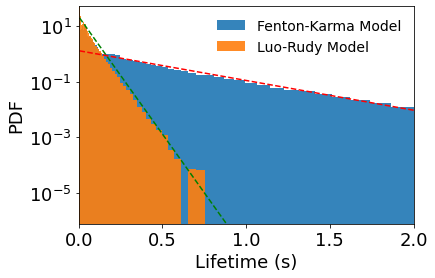

In [249]:
alpha=0.9
fontsize=18
#figure panel style histogram of lifetimes
fig,ax=plt.subplots(figsize=(6,4))
bar_heights_fk,bins,_=plt.hist(lifetime_values_FK,bins=bins,log=True,color='C0',density=True,alpha=alpha, label='Fenton-Karma Model')
bar_heights_lr,_,_=plt.hist(lifetime_values_LR,bins=bins,log=True,color='C1',density=True,alpha=alpha, label='Luo-Rudy Model')

#plot a dotted line for an exponential fit
# GammaBar_predicted=300#82
# x=0.5*(bins[1:]+bins[:-1])
# yv=22*np.exp(-x/GammaBar_predicted)
# plt.plot(x,yv,'k--')
plt.plot(x,yv_lr,'g--')
plt.plot(x,yv_fk,'r--')
plt.legend(fontsize=fontsize-4,frameon=False)
plt.xlim([0,2])#$3.5e3*1e-3])
plt.ylim([0.8e-6,5e1])
format_plot(ax=plt.gca(),xlabel='Lifetime (s)',ylabel='PDF',fontsize=fontsize)
plt.show()

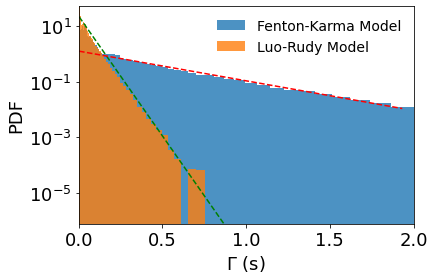

In [162]:
alpha=0.8
fontsize=18
#figure panel style histogram of lifetimes
fig,ax=plt.subplots(figsize=(6,4))
bar_heights_fk,bins,_=plt.hist(lifetime_values_FK,bins=bins,log=True,color='C0',density=True,alpha=alpha, label='Fenton-Karma Model')
bar_heights_lr,_,_=plt.hist(lifetime_values_LR,bins=bins,log=True,color='C1',density=True,alpha=alpha, label='Luo-Rudy Model')

#plot a dotted line for an exponential fit
# GammaBar_predicted=300#82
# x=0.5*(bins[1:]+bins[:-1])
# yv=22*np.exp(-x/GammaBar_predicted)
# plt.plot(x,yv,'k--')
plt.plot(x,yv_lr,'g--')
plt.plot(x,yv_fk,'r--')
plt.legend(fontsize=fontsize-4,frameon=False)
plt.xlim([0,2])#$3.5e3*1e-3])
plt.ylim([0.8e-6,5e1])
format_plot(ax=plt.gca(),xlabel=r'$\Gamma$ (s)',ylabel='PDF',fontsize=fontsize)
plt.show()

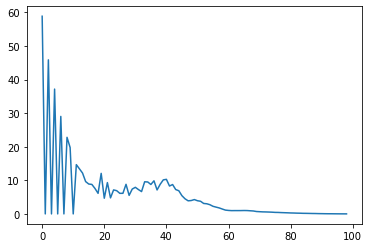

In [163]:
plt.plot(bar_heights_fk)

In [174]:
t_values=0.5*bins[1:]+0.5*bins[:-1]
cdf_values_fk=np.cumsum(np.multiply(bar_heights_fk,np.diff(bins)))
cdf_values_lr=np.cumsum(np.multiply(bar_heights_lr,np.diff(bins)))
t_values.shape,cdf_values_fk.shape,cdf_values_lr.shape

((99,), (99,), (99,))

In [175]:
np.max(cdf_values_fk),np.max(cdf_values_lr)

(1.0, 1.0000000000000002)

In [171]:
# cdf_values_lr#-cdf_values_fk
np.cumsum(bar_heights_lr).shape,np.diff(bins).shape

((99,), (99,))

In [176]:
#TODO: compute exponential fit to all values
x=0.5*(bins[1:]+bins[:-1])

print(f"exponential fit for the Fenton-Karma model:")
xmin=2e2*1e-3
xmax=2e3*1e-3
boo=x<=xmax
boo&=x>=xmin
y=cdf_values_fk#bar_heights_fk
# print_fit_exponential(x[boo],y[boo])
B,Delta_B,m,Delta_m,Rsq=fit_exponential(x[boo],y[boo])
GammaBar_observed=-1/m
Delta_GammaBar_observed=1/(m**2)*Delta_m
print(f"GammaBar_observed: {GammaBar_observed:.4f}+/-{Delta_GammaBar_observed:.4f} milliseconds")
yv=np.exp(B+x*m)
yv_fk=yv.copy()

print(f"\nexponential fit for the Luo-Rudy model:")
xmax=3e2*1e-3
boo=x<=xmax
y=cdf_values_lr#bar_heights_lr
# print_fit_exponential(x[boo],y[boo])
B,Delta_B,m,Delta_m,Rsq=fit_exponential(x[boo],y[boo])
GammaBar_observed=-1/m
Delta_GammaBar_observed=1/(m**2)*Delta_m
print(f"GammaBar_observed: {GammaBar_observed:.4f}+/-{Delta_GammaBar_observed:.4f} milliseconds")
yv=np.exp(B+x*m)
yv_lr=yv.copy()

exponential fit for the Fenton-Karma model:
GammaBar_observed: -5.3850+/-1.0578 milliseconds

exponential fit for the Luo-Rudy model:
GammaBar_observed: -0.1092+/-0.0294 milliseconds


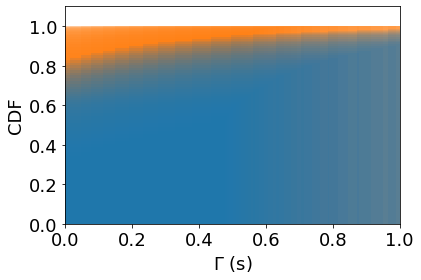

In [177]:
alpha=0.1
plt.bar(x=t_values, height=cdf_values_lr, width=0.8, bottom=None, align='center',alpha=alpha, label='Luo-Rudy Model', color='C1')
plt.bar(x=t_values, height=cdf_values_fk, width=0.8, bottom=None, align='center',alpha=alpha, label='Fenton-Karma Model', color='C0')
# plt.plot(x,yv_lr,'g--')
# plt.plot(x,yv_fk,'r--')
# plt.legend(fontsize=fontsize-2,frameon=False,loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1.1])
format_plot(ax=plt.gca(),xlabel=r'$\Gamma$ (s)',ylabel='CDF',fontsize=fontsize)
plt.show()

In [178]:
t_values[0]

0.0020722672220103234

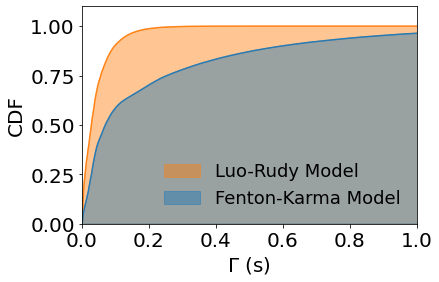

In [195]:
alpha=0.9
plt.plot(t_values, cdf_values_lr,alpha=alpha, color='C1')#, label='Luo-Rudy Model'
plt.fill_between(t_values, cdf_values_lr,alpha=alpha/2, label='Luo-Rudy Model', color='C1')
plt.plot(t_values, cdf_values_fk,alpha=alpha, color='C0')#, label='Fenton-Karma Model'
plt.fill_between(t_values, 0.*cdf_values_fk,cdf_values_fk,alpha=alpha/2, label='Fenton-Karma Model', color='C0')
# plt.plot(x,yv_lr,'g--')
# plt.plot(x,yv_fk,'r--')
plt.legend(fontsize=fontsize-2,frameon=False,loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1.1])
# format_plot(ax=plt.gca(),xlabel=r'$\Gamma$ (s)',ylabel='Survival Fraction',fontsize=fontsize)
format_plot(ax=plt.gca(),xlabel=r'$\Gamma$ (s)',ylabel='CDF',fontsize=fontsize)
plt.show()

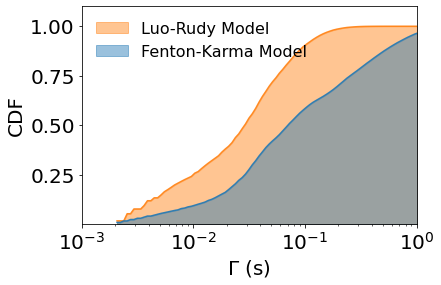

In [194]:
alpha=0.9
plt.plot(t_values, cdf_values_lr,alpha=alpha, color='C1')#, label='Luo-Rudy Model'
plt.fill_between(t_values, cdf_values_lr,alpha=alpha/2, label='Luo-Rudy Model', color='C1')
plt.plot(t_values, cdf_values_fk,alpha=alpha, color='C0')#, label='Fenton-Karma Model'
plt.fill_between(t_values, 0.*cdf_values_fk,cdf_values_fk,alpha=alpha/2, label='Fenton-Karma Model', color='C0')
# plt.plot(x,yv_lr,'g--')
# plt.plot(x,yv_fk,'r--')
plt.legend(fontsize=fontsize-4,frameon=False,loc='upper left')
# plt.legend(fontsize=fontsize-2,frameon=False,loc='lower right')
plt.xlim([1e-3,1])
plt.ylim([1e-3,1.1])
plt.xscale('log')
# forat_plot(ax=plt.gca(),xlabel=r'$\Gamma$ (s)',ylabel='Survival Fraction',fontsize=fontsize)
format_plot(ax=plt.gca(),xlabel=r'$\Gamma$ (s)',ylabel='CDF',fontsize=fontsize)
plt.show()

In [180]:
#TODO: compute cdf by accumulating the bar heights

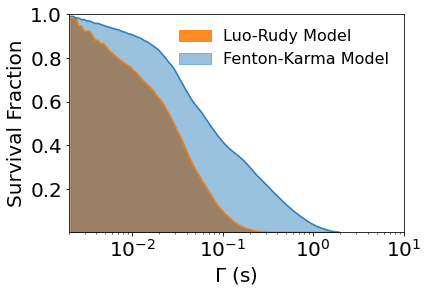

In [212]:
alpha=0.9
afrac=1.
plt.plot(t_values, 1-cdf_values_lr,alpha=alpha, color='C1')#, label='Luo-Rudy Model'
plt.fill_between(t_values, 1-cdf_values_lr,alpha=alpha/afrac, label='Luo-Rudy Model', color='C1')
plt.plot(t_values, 1-cdf_values_fk,alpha=alpha, color='C0')#, label='Fenton-Karma Model'
plt.fill_between(t_values, 0.*cdf_values_fk,1-cdf_values_fk,alpha=alpha/2, label='Fenton-Karma Model', color='C0')
# plt.plot(x,yv_lr,'g--')
# plt.plot(x,yv_fk,'r--')
plt.legend(fontsize=fontsize-4,frameon=False,loc='upper right')
# plt.legend(fontsize=fontsize-2,frameon=False,loc='lower right')
plt.xlim([2e-3,10])
plt.ylim([2e-3,1.])
plt.xscale('log')
format_plot(ax=plt.gca(),xlabel=r'$\Gamma$ (s)',ylabel='Survival Fraction',fontsize=fontsize)
# format_plot(ax=plt.gca(),xlabel=r'$\Gamma$ (s)',ylabel='CDF',fontsize=fontsize)
plt.show()

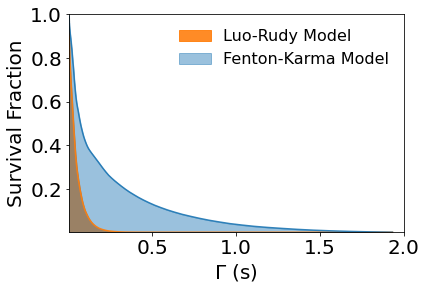

In [214]:
alpha=0.9
afrac=1.
plt.plot(t_values, 1-cdf_values_lr,alpha=alpha, color='C1')#, label='Luo-Rudy Model'
plt.fill_between(t_values, 1-cdf_values_lr,alpha=alpha/afrac, label='Luo-Rudy Model', color='C1')
plt.plot(t_values, 1-cdf_values_fk,alpha=alpha, color='C0')#, label='Fenton-Karma Model'
plt.fill_between(t_values, 0.*cdf_values_fk,1-cdf_values_fk,alpha=alpha/2, label='Fenton-Karma Model', color='C0')
# plt.plot(x,yv_lr,'g--')
# plt.plot(x,yv_fk,'r--')
plt.legend(fontsize=fontsize-4,frameon=False,loc='upper right')
# plt.legend(fontsize=fontsize-2,frameon=False,loc='lower right')
plt.xlim([2e-3,2])
plt.ylim([2e-3,1.])
# plt.xscale('log')
format_plot(ax=plt.gca(),xlabel=r'$\Gamma$ (s)',ylabel='Survival Fraction',fontsize=fontsize)
# format_plot(ax=plt.gca(),xlabel=r'$\Gamma$ (s)',ylabel='CDF',fontsize=fontsize)
plt.show()

## scratchwerk

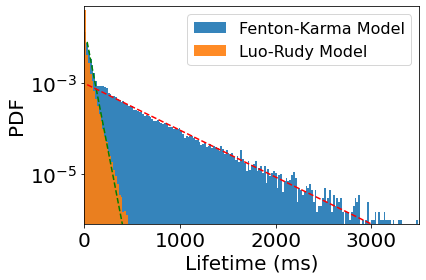

In [361]:
alpha=0.9
GammaBar_predicted=300#82
#figure panel style histogram of lifetimes
fig,ax=plt.subplots(figsize=(6,4))
bar_heights_fk,bins,_=plt.hist(lifetime_values_FK,bins=300,log=True,color='C0',density=True,alpha=alpha, label='Fenton-Karma Model')
bar_heights_lr,_,_=plt.hist(lifetime_values_LR,bins=bins,log=True,color='C1',density=True,alpha=alpha, label='Luo-Rudy Model')

#plot a dotted line for an exponential fit
# x=0.5*(bins[1:]+bins[:-1])
# yv=22*np.exp(-x/GammaBar_predicted)
# plt.plot(x,yv,'k--')
plt.plot(x,yv_lr,'g--')
plt.plot(x,yv_fk,'r--')
plt.legend(fontsize=16)
plt.xlim([0,3.5e3])
plt.ylim([0.8e-6,5e-2])
format_plot(ax=plt.gca(),xlabel='Lifetime (ms)',ylabel='PDF')
plt.show()

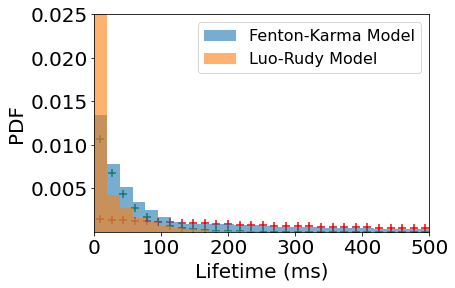

In [296]:
alpha=0.6
GammaBar_predicted=300#82
use_log=False
#figure panel style histogram of lifetimes
fig,ax=plt.subplots(figsize=(6,4))
bar_heights_fk,bins,_=plt.hist(lifetime_values_FK,bins=300,log=use_log,color='C0',density=True,alpha=alpha, label='Fenton-Karma Model')
bar_heights_lr,_,_=plt.hist(lifetime_values_LR,bins=bins,log=use_log,color='C1',density=True,alpha=alpha, label='Luo-Rudy Model')

#plot a dotted line for an exponential fit
# x=0.5*(bins[1:]+bins[:-1])
# yv=22*np.exp(-x/GammaBar_predicted)
# plt.plot(x,yv,'k--')
# plt.plot(x,yv_lr,'g--')
# plt.plot(x,yv_fk,'r--')
plt.scatter(x,yv_lr,c='g',marker='+',s=80)
plt.scatter(x,yv_fk,c='r',marker='+',s=80)
plt.legend(fontsize=16)
plt.xlim([0,.5e3])
plt.ylim([0.8e-6,2.5e-2])
format_plot(ax=plt.gca(),xlabel='Lifetime (ms)',ylabel='PDF')
plt.show()

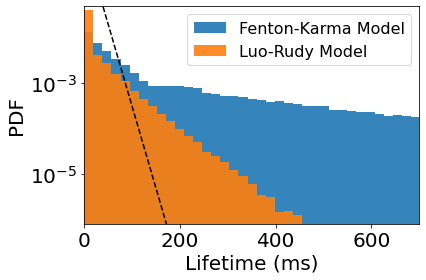

In [297]:
alpha=0.9
GammaBar_predicted=15#300#82
#figure panel style histogram of lifetimes
fig,ax=plt.subplots(figsize=(6,4))
bar_heights_fk,bins,_=plt.hist(lifetime_values_FK,bins=300,log=True,color='C0',density=True,alpha=alpha, label='Fenton-Karma Model')
bar_heights_lr,_,_=plt.hist(lifetime_values_LR,bins=bins,log=True,color='C1',density=True,alpha=alpha, label='Luo-Rudy Model')

# #plot a dotted line for an exponential fit
# x=0.5*(bins[1:]+bins[:-1])
# yv=22*np.exp(-x/GammaBar_predicted)
GammaBar_predicted=12#300#82
x=0.5*(bins[1:]+bins[:-1])
yv=13e-1*np.exp(-x/GammaBar_predicted)
# plt.scatter(x,yv,c='k',marker='+',s=80)
plt.plot(x,yv,'k--')
# plt.plot(x,yv_lr,'g--')
# plt.plot(x,yv_fk,'r--')
plt.legend(fontsize=16)
plt.xlim([0,7e2])
# plt.xlim([0,3.5e3])
plt.ylim([0.8e-6,5e-2])
format_plot(ax=plt.gca(),xlabel='Lifetime (ms)',ylabel='PDF')
plt.show()

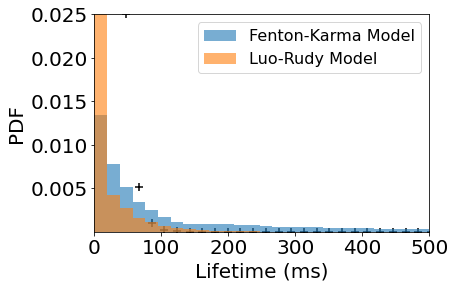

0.5898999090220495


In [260]:
alpha=0.6
use_log=False
#figure panel style histogram of lifetimes
fig,ax=plt.subplots(figsize=(6,4))
bar_heights_fk,bins,_=plt.hist(lifetime_values_FK,bins=300,log=use_log,color='C0',density=True,alpha=alpha, label='Fenton-Karma Model')
bar_heights_lr,_,_=plt.hist(lifetime_values_LR,bins=bins,log=use_log,color='C1',density=True,alpha=alpha, label='Luo-Rudy Model')

#plot a dotted line for an exponential fit
# x=0.5*(bins[1:]+bins[:-1])
# yv=22*np.exp(-x/GammaBar_predicted)
# plt.plot(x,yv,'k--')
# plt.plot(x,yv_lr,'g--')
# plt.plot(x,yv_fk,'r--')
#plot a dotted line for an exponential fit
GammaBar_predicted=12#300#82
x=0.5*(bins[1:]+bins[:-1])
yv=13e-1*np.exp(-x/GammaBar_predicted)
plt.scatter(x,yv,c='k',marker='+',s=80)
# plt.scatter(x,yv_lr,c='g',marker='+',s=80)
# plt.scatter(x,yv_fk,c='r',marker='+',s=80)
plt.legend(fontsize=16)
plt.xlim([0,.5e3])
plt.ylim([0.8e-6,2.5e-2])
format_plot(ax=plt.gca(),xlabel='Lifetime (ms)',ylabel='PDF')
plt.show()
print(np.max(yv))

In [261]:
ymax=np.max(y)
dict_linlog=compute_95CI_ols(x,-np.log(ymax/y))
dict_linlog

{'m': nan, 'Delta_m': nan, 'b': nan, 'Delta_b': nan, 'Rsquared': nan}

In [262]:
B,Delta_B,m,Delta_m,Rsq=fit_exponential(x.flatten(),y.flatten())
B,Delta_B,m,Delta_m,Rsq

(nan, nan, nan, nan, nan)

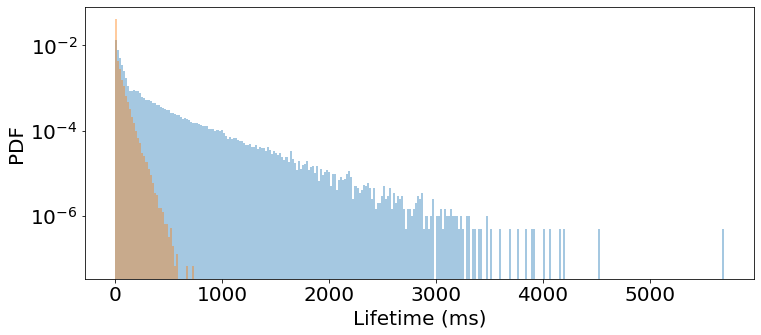

In [263]:
fig,ax=plt.subplots(figsize=(12,5))
bar_heights_fk,bins,_=plt.hist(lifetime_values_FK,bins=300,log=True,color='C0',density=True,alpha=0.4)
bar_heights_lr,_,_=plt.hist(lifetime_values_LR,bins=bins,log=True,color='C1',density=True,alpha=0.4)
format_plot(ax=plt.gca(),xlabel='Lifetime (ms)',ylabel='PDF')
plt.show()

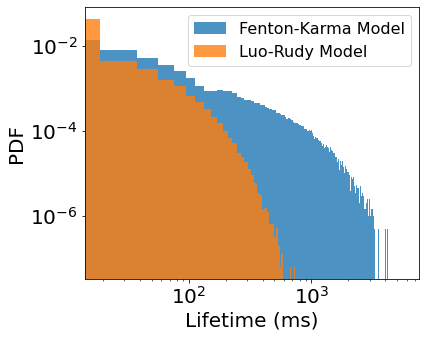

In [264]:
alpha=0.8
#figure panel style histogram of lifetimes
fig,ax=plt.subplots(figsize=(6,5))
bar_heights_fk,bins,_=plt.hist(lifetime_values_FK,bins=300,log=False,color='C0',density=True,alpha=alpha, label='Fenton-Karma Model')
bar_heights_lr,_,_=plt.hist(lifetime_values_LR,bins=bins,log=False,color='C1',density=True,alpha=alpha, label='Luo-Rudy Model')
plt.legend(fontsize=16)
format_plot(ax=plt.gca(),xlabel='Lifetime (ms)',ylabel='PDF')
plt.xscale('log')
plt.yscale('log')
plt.show()

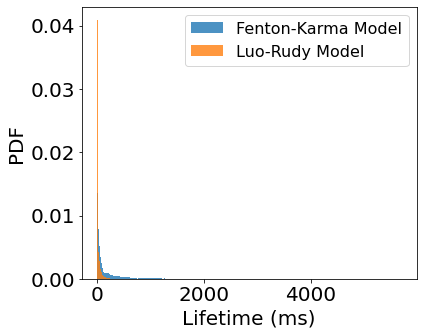

In [265]:
alpha=0.8
#figure panel style histogram of lifetimes
fig,ax=plt.subplots(figsize=(6,5))
bar_heights_fk,bins,_=plt.hist(lifetime_values_FK,bins=300,log=False,color='C0',density=True,alpha=alpha, label='Fenton-Karma Model')
bar_heights_lr,_,_=plt.hist(lifetime_values_LR,bins=bins,log=False,color='C1',density=True,alpha=alpha, label='Luo-Rudy Model')
plt.legend(fontsize=16)
format_plot(ax=plt.gca(),xlabel='Lifetime (ms)',ylabel='PDF')
plt.show()

In [266]:
bins=np.arange(0,1e3,4)
# bins

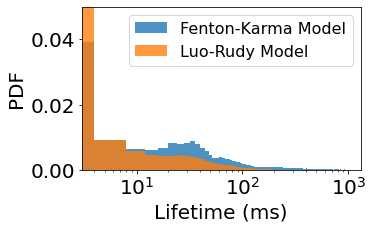

In [267]:
alpha=0.8
#figure panel style histogram of lifetimes
fig,ax=plt.subplots(figsize=(5,3))

bar_heights_fk,_,_=plt.hist(lifetime_values_FK,bins=bins,log=False,color='C0',density=True,alpha=alpha, label='Fenton-Karma Model')
# bins_fk=bins.copy()
bar_heights_lr,_,_=plt.hist(lifetime_values_LR,bins=bins,log=False,color='C1',density=True,alpha=alpha, label='Luo-Rudy Model')
# bins_lr=bins.copy()
plt.legend(fontsize=16)
format_plot(ax=plt.gca(),xlabel='Lifetime (ms)',ylabel='PDF')
plt.xscale('log')
plt.ylim([0,0.05])
plt.show()

In [268]:
#DONE: save results as pkl
import pickle

dict_lifetimes = {'lr': {'tbins':bins, 'pdf_bar_heights':bar_heights_lr},
     'fk': {'tbins':bins, 'pdf_bar_heights':bar_heights_fk}
    }

lifetime_pdf_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/lifetimes.pkl"

with open(lifetime_pdf_dir, 'wb') as handle:
    pickle.dump(dict_lifetimes, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(lifetime_pdf_dir, 'rb') as handle:
    b = pickle.load(handle)
    
# assert dict_lifetimes==b
type(b)

dict

# compute and visualize the cdf from the pdf

In [8]:
#DONE: save results as pkl
import pickle
# dict_lifetimes = {'lr': {'tbins':bins, 'pdf_bar_heights':bar_heights_lr},
#      'fk': {'tbins':bins, 'pdf_bar_heights':bar_heights_fk}
#     }
lifetime_pdf_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/lifetimes.pkl"
# with open(lifetime_pdf_dir, 'wb') as handle:
#     pickle.dump(dict_lifetimes, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(lifetime_pdf_dir, 'rb') as handle:
    dict_lifetimes = pickle.load(handle)

EOFError: Ran out of input

# (old) Computing Lifetimes of Spiral Tips
Tim Tyree<br>
6.29.2020<br>

In [12]:
#pylab
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pylab import imshow, show


import numba, trackpy, sklearn
# from numba import njit, jit, vectorize
# from PIL import Image
# import imageio
# import cv2 as cv

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()

#load the libraries
from lib import *
from lib.dist_func import *
# from lib.operari import *
# from lib.ProgressBar import *
# from lib.minimal_model import *
# from lib.TexturePlot import *
# from lib.get_tips import *
# from lib.minimal_model import *
# from lib.intersection import *
# from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
# from lib.contours_to_tips import *

%autocall 1
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'lib.dist_func'

# post process log to get tip positions

In [ ]:
# #search for input_fn "tip_log_"+ .. .._ +num+".csv"
# input_fn = search_for_file(nb_dir+'/Data/ds_5_param_set_8')
# print(input_fn)
# #TODO: find a proper way to terminate the Tk application launched by search_for_file.  it doesn't terminate


# doesn't work input_fn = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_0.5_threshold_0.9_005.csv'
# doesn't work input_fn = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_1.0_threshold_0.8_006.csv'

#I think this is the best one sigma = 1.5, threshold = 0.6
input_fn = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_1.5_threshold_0.6_006.csv'

#may nearly work /Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_1.5_threshold_0.9_006.csv
#may nearly work /Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_1.0_threshold_0.6_006.csv

In [ ]:
# input_fn = 'Log/tip_log_ds_5_sigma_1.0_threshold_0.6_001.csv'
os.chdir(nb_dir+'/Data/ds_5_param_set_8')
print(str(os.path.exists(input_fn))+" it is that input_fn exists,")
# print("have you the right sigma and threshold?")
# ds = 5; sigma = 1.0; threshold = 0.8
V_threshold = 0.5
print(f"have you the right V_threshold = {V_threshold}?")




In [ ]:
#save the tip positions expanded into rows
df_output = process_tip_log_file(input_fn, include_EP=True, include_nonlinear_EP=False)
saveherein = input_fn.replace('.csv','_processed.csv')
df_output.to_csv(saveherein, index=False)
beep(1)
print(f"and the resulting \"_processed.csv\" was supplanted herein:\n\t{saveherein}")

In [ ]:
#BLUF load processed df with tips as rows
df = pd.read_csv(input_fn)
fn = input_fn.split('/')[-1]
descrip = fn[:fn.find('_processed.csv')]
threshold = eval(fn[fn.find('threshold_')+len('threshold_'):].split('_')[0])
ds = eval(fn[fn.find('ds_')+len('ds_'):].split('_')[0])
sigma = eval(fn[fn.find('sigma_')+len('sigma_'):].split('_')[0])
print(f"(ds,sigma,threshold) = {(ds,sigma,threshold)}")

# import tip positions

In [ ]:
# high-res EP states also observed
# saveherein = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_0.5_threshold_0.9_005_processed.csv'
os.chdir('/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/trajectories')
# sigma = 0.5  #1.5#1.5#1.#1
# threshold = 0.9#0.6  #0.9#0.95

In [ ]:
#if using ^that result of tip positions expanded into rows?
data_dir = saveherein
# data_dir = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_1.0_threshold_0.8_006_processed.csv'



# sigma = 1.0  #1.5#1.5#1.#1
# threshold = 0.6#0.6  #0.9#0.95
# ext = ''#'001_'
# search_for_file()
# data_dir    = f'{nb_dir}/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_{sigma}_threshold_{threshold}_{ext}processed.csv'

# 'Log/tip_log_ds_5_sigma_1.0_threshold_0.6_001_processed.csv'
# data_dir    = f'{nb_dir}/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_{sigma}_threshold_{threshold}_processed.csv'
print(f"loading .csv of size [??{2*sys.getsizeof(data_dir)} KB] from \n\t{data_dir}")
df = pd.read_csv(data_dir)

save_folder = '/'+os.path.join(*data_dir.split('/')[:-2])+'/trajectories/'
os.chdir(save_folder)
print(f"files will be saved in the folder: \n\t{save_folder}")

In [ ]:
# test data has no odd spiral tips since the data has periodic boundary conditions
assert not (np.array(list(set(df.n.values)))%2==1).any()
print('no odd spiral tips exist.')

In [ ]:
#plot the raw spiral tip locations after time 500
x_values, y_values, t_values = df.query('t>500')[['x','y','t']].values.T
plt.scatter(x=x_values,y=y_values,c=t_values,s=0.1)
plt.show()

In [ ]:
#compute the number of spiral tips in each time frame

#TODO: determine if there are any gaps in spiral tip frame number by plotting tip number versus time
n_series = df.query('t>540')['t'].value_counts().sort_index()

# plot tip number versus time for long-lived trajectories
x_values = n_series.index.values
y_values = n_series.values
plt.plot(x_values,y_values)

In [ ]:
#plot the when there are 4 spiral tips around time 
x_values, y_values, t_values = df.query('t>554 and n>3')[['x','y','t']].values.T
plt.scatter(x=x_values,y=y_values,c=t_values,s=10)
plt.show()

In [ ]:
#plot the when there are 4 spiral tips around time 
x_values, y_values, t_values = df.query('t>540 and t<546')[['x','y','t']].values.T
plt.scatter(x=x_values,y=y_values,c=t_values,s=10)
plt.axis(axis)
plt.show()

#### DONE(ignore): get trackpy to use periodic boundary distances
- failing ^that make trackpy use my distance function

__Trackpy warns in its more seriptitious print statements that user defined distances are not tested__<br>
Thus, I must test my own use case on a test with a known response.

__How trackpy handles user defined distance functions__
The only appearance of dist_func in trackpy's source code from github is in subnet.py.  In which, trackpy.subnet.HashBTree.rebuild passes dist_func to sklearn as follows <br>
`sklearn.neighbors.BallTree(coords_mapped,metric='pyfunc', func=self.dist_func`

`sklearn.neighbors.BallTree` has func as an additional kwarg, which is passed to the distance metric class, DistanceMetric.  In the docstring of that function, I find the specification for `DistanceMetric`.

__Bottom Line Up Front (BLUF) the function must take two 1D numpy arrays and return a distance.  Everything will be slower because of the overhead of calling python functions__

In [ ]:
# from sklearn.neighbors import BallTree, DistanceMetric

In [ ]:
print('''**User-defined distance:**

===========    ===============    =======
identifier     class name         args
-----------    ---------------    -------
"pyfunc"       PyFuncDistance     func
===========    ===============    =======

Here ``func`` is a function which takes two one-dimensional numpy
arrays, and returns a distance.  Note that in order to be used within
the BallTree, the distance must be a true metric:
i.e. it must satisfy the following properties

1) Non-negativity: d(x, y) >= 0
2) Identity: d(x, y) = 0 if and only if x == y
3) Symmetry: d(x, y) = d(y, x)
4) Triangle Inequality: d(x, y) + d(y, z) >= d(x, z)

Because of the Python object overhead involved in calling the python
function, this will be fairly slow, but it will have the same
scaling as other distances.''')

In [ ]:
# this section was sent to lib.dist_func
# def get_distance_L2_pbc(width=200,height=200):
#     '''returns a function for the euclidean (L2) distance measure for a 2D rectangle with periodic boundary conditions.
#     width, height are the shape of that 2D rectangle.'''
#     @jit('f8(f8[:],f8[:])', nopython=True)
#     def distance_L2_pbc(point_1, point_2):
#         '''assumes getting shortest distance between two points with periodic boundary conditions in 2D.'''
#         mesh_shape=np.array((width,height))
#         dq2 = 0.
#         #     for q1, q2, width in zip(point_1[:2], point_2[:2], mesh_shape):
#         for q1, q2, wid in zip(point_1, point_2, mesh_shape):
#             dq2 = dq2 + min(((q2 - q1)**2, (q2 + wid - q1 )**2, (q2 - wid - q1 )**2))
#         return np.sqrt(dq2)
#     return distance_L2_pbc

# def test_get_distance_L2_pbc():
#     import trackpy, pandas as pd

#     #testing the pbc distance function
#     distance_L2_pbc = get_distance_L2_pbc(width=200,height=200)
#     assert(np.isclose(distance_L2_pbc(np.array([1.,1.]),np.array([1.,1.])),0.))
#     assert(distance_L2_pbc(np.array([1.,1.]),np.array([199.,199.]))<3.)
#     assert(distance_L2_pbc(np.array([1.,1.]),np.array([199.,199.]))<3.)
#     assert(distance_L2_pbc(np.array([1.,1.]),np.array([1.,199.]))<3.)
#     assert(distance_L2_pbc(np.array([1.,1.]),np.array([199.,1.]))<3.)

#     #testing distance_L2_pbc in trackpy.link_df
#     df_test = pd.DataFrame({'frame':[1,2,2],'x':[1,100,199],'y':[1,100,199]})

#     # test that the default distance function maps 1,1 to 100,100 instead of 199,199
#     traj_test = trackpy.link_df(df_test, search_range=210)
#     assert((traj_test['particle'].values == np.array([0, 0, 1])).all())

#     # test that the pbc distance function maps 1,1 to 199,199 instead of 100,100
#     traj_test = trackpy.link_df(df_test, search_range=210, dist_func = distance_L2_pbc)
#     assert((traj_test['particle'].values == np.array([0, 1, 0])).all())

#     # test that the pbc distance function can see accross boundarys when search_range is small
#     traj_test = trackpy.link_df(df_test, search_range=110, dist_func = distance_L2_pbc)
#     assert((traj_test['particle'].values == np.array([0, 1, 0])).all())
#     return True

# track tips using periodic boundary conditions

In [ ]:
# df_dir = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_1.5_threshold_0.9_processed.csv'
# import sklearn
df_dir = data_dir
print(data_dir)
df = pd.read_csv(df_dir)


In [ ]:
#assign each time a unique frame number
t_list =  sorted(set(df.t.values))
frameno_list = list(range(len(t_list)))
df['frame'] = -9999
for frameno, t in zip(frameno_list,t_list):
    df.loc[df.t==t, 'frame'] = frameno
#assert that all entries were given a value
assert ( not (df.frame<0).any() )

In [ ]:
#TODO: check that n is reproduced by the number of x in the trajectory file
# traj.query('t==555').t
# df['frame']

In [ ]:
# h = 0.007
mem = 2 
sr  = 40 #?works sampling every 100 frames
# sr  = 1 #works sampling every frame
distance_L2_pbc = get_distance_L2_pbc(width=200,height=200)
link_kwargs = {
    'neighbor_strategy' : 'BTree',
    'dist_func'         : distance_L2_pbc,
    'memory': mem}
# df['frame'] = np.around(df['t']/h)
# df = df.astype(dtype={'frame':int}).copy()
traj = trackpy.link_df(
    f=df,search_range=sr,t_column='frame', **link_kwargs)

beep(1)

In [ ]:
save_fn = os.path.basename(df_dir).replace('_processed.csv', f'_traj_sr_{sr}_mem_{mem}.csv')
traj.to_csv(save_fn, index=False)
print (save_fn)

In [ ]:
#plot spiral tip number versus time
# df = traj.copy()
#compute the number of spiral tips in each time frame
# df.groupby('t').describe().head()
n_series = traj['t'].value_counts().sort_index()
# plot tip number versus time for long-lived trajectories
x_values = n_series.index.values
y_values = n_series.values
plt.plot(x_values,y_values, label='n, number of trajectories (raw)')

# plot tip number versus time for all trajectories
t_values = df.t.values
n_values = df.n.values
plt.plot(t_values, n_values+1, alpha=0.5, label='1+n, measured during simulation')
plt.title("The number of trajectories reproduces \nthe originally observed n exactly.")
plt.xlabel('time (ms)')
plt.ylabel('n or n+1')
plt.legend()
plt.show()

In [ ]:
#test that every row has a nonnegative particle number
assert ( (traj.particle>=0).all() )
print ( save_fn ) 

# visualization efforts

## compute life times

particles still not being tracked right.  debug between two  time steps from the middle frames ah, search_range must be at least ~1e-2.  Using 1e-0 should work

In [ ]:
save_fn = nb_dir+'/Data/ds_5_param_set_8/trajectories/tip_trajectories_ds_5_sigma_1.5_threshold_0.6_traj_sr_1_mem_2.csv'
h = 0.007
# data_fn = 'tip_log_ds_5_sigma_1.0_threshold_0.6_traj_sr_1.csv'
df_traj = pd.read_csv(save_fn)
print(save_fn)
descrip = 'forFig1'

In [ ]:
df_traj.describe()

In [ ]:
#compute lifetimes
g = df_traj.groupby('particle')['t']
mx = g.agg(np.max)
mn = g.agg(np.min)
gd_lifetimes = mx - mn

## plot lifetimes

In [ ]:
# ll=np.max(gd_lifetimes[gd_lifetimes>0.])
# print(f"the longest living tip lasted {int(np.around(ll/h))} time steps, which was {ll:.3f} ms.")

 based on Wouter's results, we would expect a lifetime on the order of 10 ms from a birth/death rate of ~0.1/ms.  We have 557 ms of data, so we would expect on the order of 2*557*0.1=111 birth/death events.
 
 So, we expect at least one tip that lasts __10 ms__.

In [ ]:
# plt.hist?

In [ ]:
# plt.hist(out[out>-100], bins=30, density=True)

In [ ]:
ll=np.max(gd_lifetimes[gd_lifetimes>0.])
print(f"the longest living tip lasted {int(np.around(ll/h))} time steps, which was {ll:.3f} ms.")
fig_fn = save_fn.replace('.csv','.png').replace('tip_log','hist_lifetimes')
# out = np.log(gd_lifetimes)

fontsize= 25

fig, ax = plt.subplots(figsize=(8,5))
plt.hist(gd_lifetimes[gd_lifetimes>0], bins=30, density=True, log=True)
plt.ylabel('frequency', fontsize=fontsize)
plt.xlabel('lifetime (ms)', fontsize=fontsize)
ax.tick_params(axis='both', labelsize= fontsize)
plt.tight_layout()
# plt.show()
savefig_dir = f"{nb_dir}/Figures/zero_odd_births-deaths_{descrip}.png"
fig.savefig(savefig_dir,dpi=400)
print (savefig_dir)
# plt.savefig(fig_fn, dpi=300)

In [ ]:
y_values = df_traj.n.values
x_values = df_traj.t.values
plt.plot(x_values,y_values)

In [ ]:
y_values = df_traj.n.values
x_values = df_traj.t.values
plt.plot(x_values,y_values)

In [ ]:
# # (equivalently if pid's are not reused) take max and min time for each trajectory
# def get_lifetime(trajectory_list):
#     '''trajectory_list is a list of lists.  
#     return np.mean( [ len(trajectory) for trajectory in trajectory_list ], axis=0 )'''
#     return np.mean( [ len(trajectory) for trajectory in trajectory_list ], axis=0 )
# #    TODO: for a given .csv of tip positions, make their trajectories naively in trackpy


## walk through the log folder converting tip positions to tip trajectories

In [ ]:
log_dir = f"{nb_dir}/Data/ds_5_param_set_8/Log"
out_dir = f"{nb_dir}/Data/ds_5_param_set_8/trajectories"
os.chdir(log_dir)
input_fn = 'tip_log_ds_5_sigma_0.5_threshold_0.9_002_traj_sr_1_mem_2.csv'
h = 0.007
sr  = 1
def get_df_and_kwargs(input_fn, width=200,height=200, mem = 2):
    df = pd.read_csv(input_fn)
    distance_L2_pbc = get_distance_L2_pbc(width=width,height=height)
    df['frame'] = np.around(df['t']/h)
    df = df.astype(dtype={'frame':int}).copy()
    link_kwargs = {
        'neighbor_strategy' : 'BTree',
        'dist_func'         : distance_L2_pbc,
        'memory': mem}
    return df, link_kwargs

In [ ]:
#compute all _processed.csv tip logs in the Log folder
os.chdir(log_dir)
for root, dirs, files in os.walk(".", topdown=False):
    for name in dirs:
        print(os.path.join(root, name))
    for name in files:
        os.chdir(log_dir)
        df_dir = os.path.join(root, name)
        if df_dir.find('_processed.csv') !=-1:
            print(f"starting on {df_dir}...")
            df, link_kwargs = get_df_and_kwargs(input_fn=df_dir, width=200,height=200, mem = 2)
            # test whether data has no odd spiral tips since the data has periodic boundary conditions
            if (np.array(list(set(df.n.values)))%2==1).any():
                print(f'WARNING: an odd spiral tips exists in \n\t{fn}')
            
            # compute trajectories (slowest part)
            traj = trackpy.link_df(f=df,search_range=sr,t_column='frame', **link_kwargs)
            
            #save results
            os.chdir(out_dir)
            save_fn = os.path.basename(df_dir).replace('_processed.csv', f'_traj_sr_{sr}_mem_{mem}.csv').replace('tip_log','tip_trajectories')
            traj.to_csv(save_fn, index=False)

In [ ]:
beep(7)

## make a histogram for each output 

In [ ]:
sr  = 1
mem = 2
dpi = 300
h = 0.007
traj_dir = f"{nb_dir}/Data/ds_5_param_set_8/trajectories"
save_dir = f"{nb_dir}/Figures"
os.chdir(traj_dir)
fontsize=15

In [ ]:
#compute all _processed.csv tip logs in the Log folder
for root, dirs, files in os.walk(".", topdown=False):
    for name in dirs:
        print(os.path.join(root, name))
    for name in files:
        os.chdir(traj_dir)
        df_dir = os.path.join(root, name)
        if df_dir.find(f'_traj_sr_{sr}_mem_{mem}.csv') !=-1:
            print(f"starting on {df_dir}...")
            df_traj = pd.read_csv(df_dir)

#             df = pd.read_csv(data_dir)

            # compute lifetimes
            g = df_traj.groupby('particle')['t']
            mx = g.agg(np.max)
            mn = g.agg(np.min)
            gd_lifetimes = mx - mn
#             gd_lifetimes = gd['max']- gd['min']
            
            #plot results
            ll=np.max(gd_lifetimes[gd_lifetimes>0.])
            print(f"the longest living tip lasted {int(np.around(ll/h))} time steps, which was {ll:.3f} ms.")
            fig_fn = df_dir.replace('.csv','.png').replace('_traj_','hist_lifetimes')
            # out = np.log(gd_lifetimes)
            plt.hist(gd_lifetimes[gd_lifetimes>0], bins=30, density=True, log=True)
            plt.ylabel('frequency', fontsize=fontsize)
            plt.xlabel('lifetime (ms)', fontsize=fontsize)
            # plt.show()
           
            
            #save results
            os.chdir(save_dir)
            save_fn = os.path.basename(df_dir).replace(f'_traj_sr_{sr}_mem_{mem}.csv', f'_sr_{sr}_mem_{mem}.csv').replace('tip_trajectories','histogram_lifetimes')
            plt.savefig(fig_fn, dpi=dpi)
            plt.close()

## take a close look at when those n = 6 numbers flicker to n=12 during trackpy.link_df
### __answer__ frame was rounding funny like in fortran
also, my data has some frames missing, and I don't know why...<br>
TODO: see if frames are still missing when `recording` is not recomputed every timestep

In [ ]:
retval = traj.groupby('frame')['particle', 'n', 't']

In [ ]:
l = 69990
frame_indices = retval.count().loc[l-1:l+2].index
# .reduce('add')

In [ ]:
for fi in frame_indices:
    pass
#     print(df.loc[fi])


In [ ]:
l = 69990

df.loc[(df.frame >= l-2) & (df.frame <= l+2)]#[['particle', 'n', 't']]

In [ ]:
# frame_indices = retval.count().loc[l-1:l+2].index

In [ ]:
traj.loc[(traj.frame >= l-2) & (traj.frame <= l+2)]

How am I computing the field "frame"? How is it rounding?

In [ ]:
df['frame'] = np.around(df['t']/h)
df = df.astype(dtype={'frame':int}).copy()

In [ ]:
df = traj.copy()
df['frame'] = np.around(df['t']/h)
df = df.astype(dtype={'frame':int}).copy()
df.loc[(traj.frame >= l-2) & (traj.frame <= l+2)]

##  spiral tip investigating tips with small lifetimes
- TODO: plot tip number versus time for trajectories and raw positions
    - Does tip doubling still exist?
    - if so, consider investigating tip doubling near missing frames explicitely plug into trackpy.link_df


- TODO: select tips with short lifetimes. visualize.
- TODO: select tips with long lifetimes. visualize.

 - TODO(later): compute the velocity of a given tip that doesn't cross the periodic boundaries



## select the long life time spiral tips and plot their birth death rates

In [ ]:
!pwd

In [ ]:
#import most recent tip trajectory data and the corresponding raw tips
data_dir_traj = f"{nb_dir}/Data/ds_5_param_set_8/trajectories"
# data_fn_traj  = 'tip_trajectories_ds_5_sigma_1.0_threshold_0.9_traj_sr_1_mem_2.csv' # nice trajectories
data_fn_traj  = 'tip_log_ds_5_sigma_0.5_threshold_0.9_005_traj_sr_1_mem_2.csv'# has EP data but has broken trajectories
data_fn = data_fn_traj
# data_dir_log  = f"{nb_dir}/Data/ds_5_param_set_8/Log"
# data_fn_log_processed = 'tip_log_ds_5_sigma_1.0_threshold_0.6_processed.csv'
# data_fn_log = 'tip_log_ds_5_sigma_1.0_threshold_0.6_001.csv' #not terribly useful

os.chdir(data_dir_traj)
df = pd.read_csv(data_fn_traj)
# select only data after 100 milliseconds
df = df[df.t>100].copy()

print('tip trajectories:')
df.head()

In [ ]:
# os.chdir(data_dir_log)
# df_log = pd.read_csv(data_fn_log_processed)

# # select only data after 100 milliseconds
# df_log = df_log[df_log.t>100].copy()
# print('tip log processed:')
# df_log.head()

## do spiral tips with a sufficiently large lifetime reproduce known results?

In [ ]:
# df.describe()

In [ ]:
#TODO: test for gaps in a given trajectory
#TODO: test for consistency between frame and time

In [ ]:
xmin=0; ymin=0; xmax=200; ymax=200; 
axis = [xmin,xmax,ymin,ymax]


In [ ]:
#naive computation of lifetime for a given tip
def get_lifetime(pid,df):
    mx,mn = df[(df.particle==pid)].t.describe()[['max','min']]
    lifetime = mx-mn #milliseconds
    return lifetime

pid_values = np.array(list(set(df.particle.values)))
# lifetime_values = [0.*pid for pid in pid_values]

lifetime_values = np.array([get_lifetime(pid,df) for pid in pid_values])




In [ ]:
# plot tip number versus time for all trajectories
t_values = df.t.values
n_values = df.n.values
plt.plot(t_values, n_values, alpha=0.5)

In [ ]:
# len(lifetime_values[boo])

In [ ]:
# plt.hist(x)

In [ ]:
#the above spiral tip lifetime estimates may not be accurate.  But W±1 = 0...
#TODO: plot the xy positions of the long lived spiral tips, coloring by pid.


In [ ]:
#plot the xy trajectory for longliving tips
saving = False
fig, ax = plt.subplots(figsize=(5, 5))
fontsize=16

LT_thresh = 2 #14 = 0.007*2000
boo = (lifetime_values>LT_thresh)
savefig_dir = f'{nb_dir}/Figures/lifetime_analysis'
savefig_fn = data_fn.replace('.csv',f'_lifetimes_longerthan_{LT_thresh:.2f}_005.png')

df_traj = df.copy()
for pid in pid_values[boo]:
    x_values ,y_values = df_traj[(df_traj.particle==pid) ][['x','y']].values.T
    plt.scatter(x_values,y_values, s=.1)
    plt.scatter([x_values[0]],[y_values[0]], s=10,color='black')
plt.axis(axis)
plt.title(f'''spiral tip lasting more than {LT_thresh:.2f} ms
(tips start at black dots)''', fontsize=fontsize)
ax.set_xlabel('x coordinate (pixels)', fontsize=fontsize)
ax.set_ylabel('y coordinate (pixels)', fontsize=fontsize)
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_dir)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}.")

__Long Lifetimes at later times look reasonable__<br>
for ^these lifetimes, the spatial trajectories appear robust when considering only lifetimes 1.5ms or longer, but not for 1.0ms or shorter.  Many of the spiral tips with high frequencies are removed by ommiting data shortly after initialization (considering only times greater than t=100ms).

### testing for sensitivity to LT_thresh
The total number of spiral tips appears reletivley stable when considering only spiral tips with a lifetime greater than 2 milliseconds.

In [ ]:
x_values = np.linspace(1,15,100)
y_values = []
for LT_thresh in x_values:
    boo = (lifetime_values>LT_thresh)
    number_of_particles = lifetime_values[boo].shape[0]
    y_values.append(number_of_particles)
y_values = np.array(y_values)

In [ ]:
#plot total particle number versus LT_thresh.  
#plot the xy trajectory for longliving tips
saving = True
savefig_fn = 'total_num_tips_versus_minimum_lifetime_threshold_zoomed.png'
fig, ax = plt.subplots(figsize=(4, 4))
fontsize=16

ax.plot(x_values,y_values)
# ax.set_title('total number of spiral tips observed after time t=100ms', fontsize=fontsize)
ax.set_xlabel('min. lifetime threshold (ms)', fontsize=fontsize)
ax.set_ylabel('total num. tips', fontsize=fontsize)
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_dir)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}.")

In [ ]:

# #TODO: plot a better histogram of tips lifetimes
# boo = (lifetime_values>0.007*2000)
# mu = 200
# sigma = 25
# n_bins = 50
# x = lifetime_values[boo]

# fig, ax = plt.subplots(figsize=(8, 4))

# # plot the cumulative histogram
# n, bins, patches = ax.hist(x, n_bins, density=True, histtype='step',
#                            cumulative=True, label='Empirical')

# # Add a line showing the expected distribution.
# y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
#      np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
# y = y.cumsum()
# y /= y[-1]

# ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')

# # Overlay a reversed cumulative histogram.
# ax.hist(x, bins=bins, density=True, histtype='step', cumulative=-1,
#         label='Reversed emp.')

# # tidy up the figure
# ax.grid(True)
# ax.legend(loc='right')
# ax.set_title('Cumulative step histograms')
# ax.set_xlabel('spiral tip lifetime (sec)')
# ax.set_ylabel('Likelihood of occurrence')


## plot a histogram of spiral tip lifetimes when considering only these features

Despite this lifetime spiral tips still exist.  Since the xy-plots of the trajectories look reasonable, it is worth considering what may distinguish these spiral tips.  
- TODO: plot birth death rates of spiral tips when only considering these tips

- TODO: plot local EP properties for short-lived and long-lived spiral tips

In [ ]:
LT_thresh = 2
boo = (lifetime_values>LT_thresh)
x = lifetime_values[boo]
plt.hist(x, bins=30)


In [ ]:
#plot the xy trajectory for longliving tips
saving = True
fig, ax = plt.subplots(figsize=(5, 4))
fontsize=16


savefig_dir = f'{nb_dir}/Figures/lifetime_analysis'
savefig_fn = 'spiral_tip_histogram.png'

for pid in pid_values[boo]:
    ax.hist(x, bins = 30)#, color='b')
# plt.axis(axis)
ax.set_title(f'''spiral tip lifetimes don't appear unimodal \n(no unreasonably brief spiral tips)''', fontsize=fontsize)
ax.set_xlabel('lifetime (ms)', fontsize=fontsize)
ax.set_ylabel('frequency', fontsize=fontsize)
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_dir)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}.")

In [ ]:
xcoord_mesh, ycoord_mesh = np.meshgrid(np.arange(0,200),np.arange(0,200))

In [ ]:
df.particle==5

# EP states are jumpy as they are, (even for the cubic spline?)
- TODO: check that cubic spline is actually rough
histogram of EP states

In [ ]:
#import most recent tip trajectory data and the corresponding raw tips
data_dir_traj = f"{nb_dir}/Data/ds_5_param_set_8/trajectories"
# data_fn_traj  = 'tip_trajectories_ds_5_sigma_1.0_threshold_0.9_traj_sr_1_mem_2.csv' # nice trajectories
data_fn_traj  = 'tip_log_ds_5_sigma_0.5_threshold_0.9_005_traj_sr_1_mem_2.csv'# has EP data but has broken trajectories
data_fn = data_fn_traj
# data_dir_log  = f"{nb_dir}/Data/ds_5_param_set_8/Log"
# data_fn_log_processed = 'tip_log_ds_5_sigma_1.0_threshold_0.6_processed.csv'
# data_fn_log = 'tip_log_ds_5_sigma_1.0_threshold_0.6_001.csv' #not terribly useful

os.chdir(data_dir_traj)
df = pd.read_csv(data_fn_traj)
# select only data after 100 milliseconds
df = df[df.t>100].copy()

# print('tip trajectories:')
# df.head()
df.columns.values

In [ ]:
# def unwrap_EP(df, 
#               EP_col_name = 'states_interpolated_linear', 
#               drop_original_column=False):
#     EP_col_exists =  EP_col_name in df.columns.values
#     if not EP_col_exists:
#         print(f"Caution! EP_col_name '{EP_col_exists}' does not exist. Returning input df.")
#         return df
#     else:
#         V_lst = []
#         f_lst = []
#         s_lst = []
#         for index, row in df.iterrows():
#             try:
#                 V,f,s = row[EP_col_name]
#             except Exception as e:
#                 V,f,s = eval(row[EP_col_name])
#             V_lst.append(V)
#             f_lst.append(f)
#             s_lst.append(s)
#         df['V'] = V_lst
#         df['f'] = f_lst
#         df['s'] = s_lst   
#         df.drop(columns=[EP_col_name], inplace=True)
#         return df

In [ ]:
df = unwrap_EP(df, EP_col_name = 'states_interpolated_linear').copy()
plt.plot(df.loc[df.particle==119].V.values)

In [ ]:
df = unwrap_EP(df, EP_col_name = 'states_interpolated_cubic').copy()
plt.plot(df.loc[df.particle==119].V.values)

In [ ]:
df = unwrap_EP(df, EP_col_name = 'states_nearest').copy()
plt.plot(df.loc[df.particle==119].V.values)

In [ ]:
LT_thresh = 2
boo = (lifetime_values>LT_thresh)
V_lst = []
f_lst = []
s_lst = []
for pid in pid_values[boo]:
    V,f,s = eval(df.loc[df.particle==pid]['states_interpolated_cubic'].tail(1).values[0])
    V_lst.append(V)
    f_lst.append(f)
    s_lst.append(s)
    

In [ ]:
x = np.array(V_lst)

fig, ax = plt.subplots(figsize=(5, 4))
fontsize=16

ax.hist(x)
ax.set_title('voltage at last observed location\nfor spiral tips living longer than 2ms')
ax.set_xlabel('$V_{mem}$ (normalized)',fontsize=fontsize)
ax.set_ylabel('freq.',fontsize=fontsize)



In [ ]:
arr = []
for si in df.loc[df.particle==pid]['states_nearest'].values:
    si = eval(si)
    arr.append(si)

In [ ]:
a,b,c = np.array(arr).T
t_values = df.loc[df.particle==pid]['t'].values
t_values = t_values-t_values[0]

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
fontsize=16

plt.plot(t_values, a, label = 'voltage')
plt.plot(t_values, b, label = 'fast var')
plt.plot(t_values, c, label = 'slow var')

ax.set_title('EP state of an example spiral tip (nearest)',fontsize=fontsize)
ax.set_xlabel('time (ms)',fontsize=fontsize)
ax.set_ylabel('value',fontsize=fontsize)
ax.legend()

In [ ]:
t_values.values

In [ ]:
#plot the xy trajectory for longliving tips
saving = False
fontsize=16
# df_traj = df.copy()
df = df[df.t>100].copy()

savefig_dir = f'{nb_dir}/Figures/lifetime_analysis'
savefig_fn = data_fn.replace('.csv',f'_lifetimes_longerthan_{LT_thresh:.2f}_005.png')

xmin=0; ymin=0; xmax=200; ymax=200; 
axis = [xmin,xmax,ymin,ymax]

fig, ax = plt.subplots(figsize=(5, 5))
for pid in pid_values[boo]:
    x_values ,y_values = df_traj[(df_traj.particle==pid) ][['x','y']].values.T
    plt.scatter(x_values,y_values, s=.1)
    plt.scatter([x_values[0]],[y_values[0]], s=10,color='black')
plt.axis(axis)
plt.title(f'''spiral tip lasting more than {LT_thresh:.2f} ms
(tips start at black dots)''', fontsize=fontsize)
ax.set_xlabel('x coordinate (pixels)', fontsize=fontsize)
ax.set_ylabel('y coordinate (pixels)', fontsize=fontsize)
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_dir)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}.")

# recompute birth/death rates, considering only the long-lived spiral tips

In [ ]:
#TODO: the first and last time point for each trajectory
#TODO: using ^this data as numerical input alone, compute the number of spiral tips as a function of time
#TODO: refer to existing birth-death rate method

In [ ]:
# #import most recent tip trajectory data and the corresponding raw tips
# data_dir_traj = f"{nb_dir}/Data/ds_5_param_set_8/trajectories"
# data_fn_traj  = 'tip_trajectories_ds_5_sigma_1.0_threshold_0.9_traj_sr_1_mem_2.csv' # nice trajectories

tmin = 50#100
LT_thresh = 0#2 #14 = 0.007*2000

#import most recent tip trajectory data and the corresponding raw tips
data_dir_traj = f"{nb_dir}/Data/ds_5_param_set_8/trajectories"
# data_fn_traj  = "tip_log_ds_5_sigma_1.0_threshold_0.8_006_traj_sr_10_mem_2.csv"
data_fn_traj  = 'tip_log_ds_5_sigma_1.5_threshold_0.6_006_traj_sr_40_mem_2.csv'
# data_fn_traj = save_fn
print ( data_fn_traj )
os.chdir(data_dir_traj)
df = pd.read_csv(data_fn_traj)
# select only data after 100 milliseconds
df = df[df.t>tmin].copy()

#naive computation of lifetime for a given tip
def get_lifetime(pid,df):
    mx,mn = df[(df.particle==pid)].t.describe()[['max','min']]
    lifetime = mx-mn #milliseconds
    return lifetime

pid_values = np.array(list(set(df.particle.values)))
lifetime_values = np.array([get_lifetime(pid,df) for pid in pid_values])

#get a DataFrame of only the long lived spiral tips

boo = (lifetime_values>LT_thresh)
boo_long = (df.particle is None)
for pid in pid_values[boo]:
    boo_long |= (df.particle==pid)
    
df = df[boo_long].copy()

In [ ]:
#compute the number of spiral tips in each time frame
# df.groupby('t').describe().head()
n_series = df['t'].value_counts().sort_index()

In [ ]:
#compute the number of spiral tips in each time frame
# df.groupby('t').describe().head()
n_series = df['t'].value_counts().sort_index()
# plot tip number versus time for long-lived trajectories
x_values = n_series.index.values
y_values = n_series.values
plt.plot(x_values,y_values)

In [ ]:
#plot the xy trajectory for longliving tips
saving = False
fontsize=16
df_traj = df.query('t < 110 and t > 90').copy()
# df_traj = df.query('t > 500').copy()
savefig_dir = f'{nb_dir}/Figures/lifetime_analysis'
savefig_fn = data_fn.replace('.csv',f'_mistake_still_exists?_sigma_{sigma}_threshold_{threshold}.png')

xmin=0; ymin=0; xmax=200; ymax=200; 
axis = [xmin,xmax,ymin,ymax]

fig, ax = plt.subplots(figsize=(5, 5))
for pid in list(set(df_traj['particle'].values)):
    x_values ,y_values, c_values = df_traj[(df_traj.particle==pid)][['x','y', 't']].values.T 
    plt.scatter(x_values,y_values, s=.1, c=c_values, vmin = 500, vmax = 600)
    
    plt.scatter([x_values[0]],[y_values[0]], s=10,color='green')
    plt.scatter([x_values[-1]],[y_values[-1]], s=10,color='red')
plt.axis(axis)
plt.title(f'''mistakes still made when t>500ms \nfor $\sigma={sigma}$ and threshold={threshold}
(tips start at green dots)''', fontsize=fontsize)
ax.set_xlabel('x coordinate (pixels)', fontsize=fontsize)
ax.set_ylabel('y coordinate (pixels)', fontsize=fontsize)
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_dir)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}.")

a spiral tip was not detected off and on for the end there.
- I plotted trajectories for times > 500, and the gaps appear large.
- TODO: plot all trajectories for time > 500.  
    - is the tracking picking up most of the spiral tip points?
    - do 2 trajectories appear to collide at the end?
    - if so, estimate their apparent interaction distance and life time
    
Looking at the histograms of n versus t, we see the missing tips happening at the same time as extra tips in the original trajectories.  This suggests that perhaps a time frame rounding error could be responsible for these errors, which would be great, since this would mean the method appears to work for these parameters.
- TODO: confirm or refute the problem is due to frame number rounding
- restarted without rounding time (using floating point precision times)

sigma = 1.5, threshold = 0.6 looks believable after time 500, does it look believable near time 100? Yes.

# compute birth/death rates with long tips
- #TODO: plot birth death rates versus spiral tip number

then,
for the sigma=1.5, threshold=0.6 method
- #TODO: plot the 
- #TODO: determine the earliest time where a spiral tip briefer than 2ms exists

- #TODO: combine the working method "as is" into a new notebook
- #TODO: automate postprocessing in that notebook 
- #TODO: (if needed)automate tracking in that notebook
- #TODO: automate computing birth death rates versus spiral tip number

In [ ]:
#filter trajectories and compute the (filtered) spiral tip number as a function of time. store in df
tmin = 50#100
LT_thresh = 2#0#0#2 #14 = 0.007*2000

#import most recent tip trajectory data and the corresponding raw tips
data_dir_traj = f"{nb_dir}/Data/ds_5_param_set_8/trajectories"
data_fn_traj  = 'tip_log_ds_5_sigma_1.5_threshold_0.6_006_traj_sr_40_mem_2.csv'
# data_fn_traj = save_fn
print (f"loading from:")
print ( data_fn_traj )
os.chdir(data_dir_traj)
df = pd.read_csv(data_fn_traj)
# select only data after 100 milliseconds
df = df[df.t>tmin].copy()

#naive computation of lifetime for a given tip
def get_lifetime(pid,df):
    mx,mn = df[(df.particle==pid)].t.describe()[['max','min']]
    lifetime = mx-mn #milliseconds
    return lifetime

pid_values = np.array(list(set(df.particle.values)))
lifetime_values = np.array([get_lifetime(pid,df) for pid in pid_values])

#get a DataFrame of only the long lived spiral tips

boo = (lifetime_values>LT_thresh)
boo_long = (df.particle is None)
for pid in pid_values[boo]:
    boo_long |= (df.particle==pid)
df = df[boo_long].copy()
n_series = df['t'].value_counts().sort_index()

#explicitely append the last death when n becomes zero
last_two_times = n_series.index.values[-2:]
h = np.diff(last_two_times)
end_time= last_two_times[-1]+h
n_series = n_series.append(pd.Series([0], index=[float(end_time)]))

#store as a pandas.DataFrame
df = pd.DataFrame({"t":n_series.index.values,"n":n_series.values})

In [ ]:
#compute birth death rates
df['dn'] = df.n.diff().shift(-1)
df = df.query('dn != 0').copy()
rates = 1/df['t'].diff().shift(-1).dropna() # birth death rates in unites of 1/ms
df['rates'] = rates
# df.dropna(inplace=True)

In [ ]:
# n_array = n_series.values
# W_array = np.diff(n_array)
# boo = W_array != 0 
df

In [ ]:
x_values = df.query('dn==2').n/2
y_values = df.query('dn==2').rates
plt.scatter(x=x_values,y=y_values, c='g', label='$W_{+2}$')
x_values = df.query('dn==-2').n/2
y_values = df.query('dn==-2').rates
plt.scatter(x=x_values,y=y_values, c='r', label='$W_{-2}$')

plt.legend()
plt.xlabel('n/2')
plt.ylabel('rate (ms$^{-1}$)')